# Deep Snakes
by Hermes, Channel and Jeanne. Rio de Janeiro, Brazil, 2018.

## Welcome to project Deep Snakes

In this series, we will try different machine learning approaches to identify two classes of snakes; python snakes (family pythonidae) and rattlesnakes (genera crotalus and sistrurus).

## Dataset
The dataset was obtained downloading free-to-share images from the web using the keywords "python snake" and "rattlesnake". Anyone interested can find the python programatic approach to downloading images "BingImagesAPI.py" on the root folder (credits to [Adrian Rosebrock](https://www.pyimagesearch.com/2018/04/09/how-to-quickly-build-a-deep-learning-image-dataset/?utm_campaign=Artificial%2BIntelligence%2Band%2BDeep%2BLearning%2BWeekly&utm_medium=email&utm_source=Artificial_Intelligence_and_Deep_Learning_Weekly_56)).

After a quick visual cleanup, the dataset contains 317 images of pythons and 288 images of rattlesnakes. After downloading those images, we preprocessed them to be 128x128 pixels, generated the train and dev datasets and stored them in an HDF5 file. Again, anyone interested in seeing how this was done can refer to "PreprocessDataset.py".
### Caveats regarding the images
Because the data came from search engines, it is possible that the datasets contain some known issues:
* Incorrect labling.
* Non python and non rattlesnakes images
* Repeated images

We did our best to eliminate these problems. Regarding the third issue, some repeated images comes in different sizes and extensions, making it tough to eliminate duplicates visually. We may try to solve this later using encoding techniques.

If you find other types of errors as well as wants to contribute in dealing with these problems, please let us know.

In [1]:
import numpy as np
import h5py as h5
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

### Understanding the dataset
A little tiny bit of exploratory data analisys.

In [2]:
# Extracting the train dataset from the h5 file.
f = h5.File("./dataset/train_set.hdf5",'r')
print("Stored data:",list(f.keys()))
# Storing the original data "permanently".
images_train_orig = f["images_train"].value
labels_train_orig = f["labels_train"].value
f.close()
# Extracting the dev dataset from the h5 file.
f = h5.File("./dataset/dev_set.hdf5",'r')
print("Stored data:",list(f.keys()))
# Storing the original data "permanently".
images_dev_orig = f["images_dev"].value
labels_dev_orig = f["labels_dev"].value
f.close()

Stored data: ['images_train', 'labels_train']
Stored data: ['images_dev', 'labels_dev']


In [3]:
print("Train set")
print("Images shape:", images_train_orig.shape)
print("Images dtype:", images_train_orig.dtype)
print("Min, max and mean pixel values:", images_train_orig.min(),"-",
      images_train_orig.max(),"-","{:5.1f}".format(images_train_orig.mean()))
print("Labels shape:", labels_train_orig.shape)
print("Labels dtype:", labels_train_orig.dtype)

Train set
Images shape: (484, 128, 128, 3)
Images dtype: uint8
Min, max and mean pixel values: 0 - 255 - 106.1
Labels shape: (484,)
Labels dtype: uint8


In [4]:
print("Dev set")
print("Images shape:", images_dev_orig.shape)
print("Images dtype:", images_dev_orig.dtype)
print("Min, max and mean pixel values:", images_dev_orig.min(),"-",
      images_dev_orig.max(),"-","{:5.1f}".format(images_dev_orig.mean()))
print("Labels shape:", labels_dev_orig.shape)
print("Labels dtype:", labels_dev_orig.dtype)

Dev set
Images shape: (121, 128, 128, 3)
Images dtype: uint8
Min, max and mean pixel values: 0 - 255 - 106.8
Labels shape: (121,)
Labels dtype: uint8


In this dataset, pythons have label 1 and rattlesnakes have label 0. So let's take a look at the pictures.

In [5]:
def species(i):
    if i == 1:
        name = "python"
    elif i==0:
        name = "rattlesnake"
    else:
        name = "dunno"
    return name

Label = 0 - A wild rattlesnake appears.


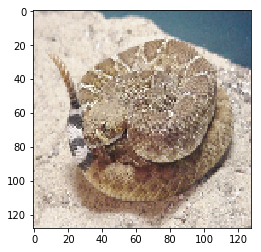

In [6]:
i = 7
print("Label =",labels_train_orig[i],"- A wild", species(labels_train_orig[i]), "appears.")
plt.imshow(images_train_orig[i])
plt.show()

### Preparing the data
As we saw earlyer, images are stored using 0-255 pixel values. We will scale them to 0-1 float values.
Also, we linearize the pixel values on width, height and channels for each image.

In [7]:
# Copying the original data for manipulation.
images_train = images_train_orig
labels_train = labels_train_orig.reshape([1,len(labels_train_orig)])
images_dev = images_dev_orig
labels_dev = labels_dev_orig.reshape([1,len(labels_dev_orig)])
# Scaling the data
images_train = images_train/255
images_train = images_train.reshape((len(images_train),-1))
images_train = images_train.transpose()
images_dev = images_dev/255
images_dev = images_dev.reshape((len(images_dev),-1))
images_dev = images_dev.transpose()
# Shapes
imsize = images_train.shape[0]
print("Images train shape")
print(images_train.shape)
print(labels_train.shape)
print("Images dev shape")
print(images_dev.shape)
print(labels_dev.shape)

Images train shape
(49152, 484)
(1, 484)
Images dev shape
(49152, 121)
(1, 121)


## Logistic Regression
Logistic regression (LR) is one of the simplest classification methods available, and shares important key ideas with shallow and deep neural networks, which we will use later. Although it's arguable that we can call LR a neural learning procedure, we will consider it so for the sake of this project's consistency. From now on, we will build all models' core engines using TensorFlow.

### Building the model
Now that our data is ready, let's build the model in tensorflow.

In [8]:
# Create placeholder for images, call it X.
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(imsize,None))
Y = tf.placeholder(tf.float32,shape=(1,None))
# Create weights and biases. Initialize to zero.
W = tf.get_variable("W", [1,imsize], initializer=tf.zeros_initializer())
b = tf.get_variable("b", [1],initializer=tf.zeros_initializer())
# Make the affine transformation
logits = tf.add(tf.matmul(W,X),b)
# Calculating the cost
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=logits))

### Training the model
Training a logistic regression is pretty straightforward as demonstrated below. We use gradient descent optimizer, considering the gradient on the mean logloss over the whole trainning dataset. We also compute and store the cost on the dev dataset to analize the out-of-sample error.

In [9]:
epochs = 500
alpha = 0.001
# Creating the optimizer
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(cost)
# Initializing global variables
init = tf.global_variables_initializer()
# Running session
with tf.Session() as sess:
    sess.run(init)
    costs_train = []
    costs_dev = []
    for epoch in range(epochs):
        _,epoch_cost = sess.run([optimizer,cost],feed_dict={X:images_train,Y:labels_train})
        costs_train.append(epoch_cost)
        cost_dev = sess.run(cost,feed_dict={X:images_dev,Y:labels_dev})
        print(epoch,epoch_cost, cost_dev)
        costs_dev.append(cost_dev)
    Weights, Bias = sess.run([W,b])

0 0.693146 0.694616
1 0.690279 0.687355
2 0.687761 0.692589
3 0.685719 0.682684
4 0.684336 0.694633
5 0.684001 0.680871
6 0.685164 0.705157
7 0.688865 0.686757
8 0.695748 0.732449
9 0.707973 0.708443
10 0.724312 0.782413
11 0.747733 0.74565
12 0.768768 0.838044
13 0.794094 0.776882
14 0.804474 0.870201
15 0.820696 0.788971
16 0.817722 0.879041
17 0.82691 0.789776
18 0.818004 0.877977
19 0.824407 0.786828
20 0.813939 0.873953
21 0.819312 0.782918
22 0.808702 0.869184
23 0.813577 0.778853
24 0.803215 0.864294
25 0.807753 0.774857
26 0.797736 0.859463
27 0.801997 0.770991
28 0.792341 0.854743
29 0.796352 0.76727
30 0.787053 0.850154
31 0.790836 0.763697
32 0.781879 0.845701
33 0.785451 0.760269
34 0.776823 0.841388
35 0.780198 0.756983
36 0.771883 0.837214
37 0.775076 0.753833
38 0.76706 0.833176
39 0.770083 0.750814
40 0.76235 0.829274
41 0.765215 0.747922
42 0.757751 0.825502
43 0.760469 0.745148
44 0.753261 0.821857
45 0.755841 0.742489
46 0.748875 0.818335
47 0.751326 0.739938
48 0.74

381 0.431002 0.628158
382 0.430664 0.628159
383 0.430326 0.628153
384 0.429989 0.628153
385 0.429653 0.628148
386 0.429317 0.628147
387 0.428982 0.628143
388 0.428648 0.628142
389 0.428314 0.628138
390 0.427981 0.628137
391 0.427648 0.628134
392 0.427316 0.628133
393 0.426984 0.62813
394 0.426653 0.628129
395 0.426323 0.628126
396 0.425993 0.628125
397 0.425664 0.628123
398 0.425336 0.628122
399 0.425008 0.62812
400 0.42468 0.628119
401 0.424354 0.628117
402 0.424027 0.628116
403 0.423702 0.628114
404 0.423376 0.628113
405 0.423052 0.628112
406 0.422728 0.628111
407 0.422405 0.62811
408 0.422082 0.628109
409 0.421759 0.628108
410 0.421438 0.628108
411 0.421117 0.628107
412 0.420796 0.628106
413 0.420476 0.628106
414 0.420157 0.628105
415 0.419838 0.628105
416 0.419519 0.628104
417 0.419202 0.628104
418 0.418884 0.628104
419 0.418568 0.628104
420 0.418251 0.628104
421 0.417936 0.628104
422 0.417621 0.628104
423 0.417306 0.628104
424 0.416992 0.628104
425 0.416679 0.628105
426 0.416366 0

### Error curves
We plot the train and dev set error stored during training to view the behavior of the optimizaton scheme.

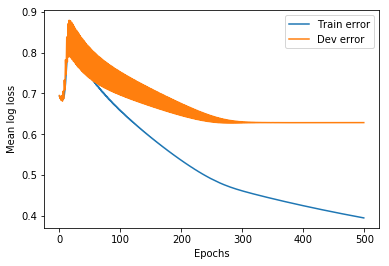

In [10]:
train_curve, = plt.plot(costs_train, label = 'Train error')
test_curve,  = plt.plot(costs_dev, label = 'Dev error')
plt.legend(handles=[train_curve,test_curve])
plt.xlabel('Epochs')
plt.ylabel('Mean log loss')

First, for both sets, there is an initial small decrease in error, folowed by a longer increase path and later an even longer decrease, in other words, our training path presents an initial instability in the learning algorithm but stabilizes later. Second, although the train set curve is pretty smooth, the dev set error oscillates heavily untill little more than 300 epochs. Third, although there is no visible plateau in the train set curve within this epoch range, the dev set plateaus over about 300 epochs, where no significant improvement occurs thereafter.

### Model accuracy
We begin by creating two simple functions. One to calculate the predicted values by the trained model given a set of pictures and the parameters trained by the model, and another to calculate the percentage of right predictions given a 0.5 probability threshold.

In [11]:
def predict(x,w,b):
    z = np.dot(w,x)+b
    probs = 1/(1+np.exp(-z))
    y_pred = (probs > 0.5).astype(int)
    return y_pred

In [12]:
def accuracy(label,y_pred):
    acc = np.mean(np.equal(label,y_pred))
    return acc

We can now assess the model's accuracy on both sets.

In [13]:
y_train_pred = predict(images_train,Weights,Bias)
acc = accuracy(labels_train,y_train_pred)
print("Train set accuracy:", acc)
y_dev_pred = predict(images_dev,Weights,Bias)
acc = accuracy(labels_dev,y_dev_pred)
print("Dev set accuracy:",acc)

Train set accuracy: 0.913223140496
Dev set accuracy: 0.652892561983


## Testing the prediction
Below, you can see where the model got it right on the train set.

It says it's a python, it's actually a python
Good guess model! Take a cookie.


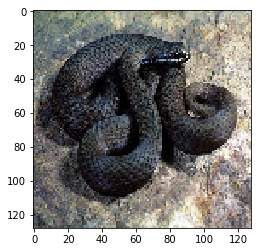

In [14]:
i = 0
sample = images_train[:,i]
target = labels_train[0,i]
prediction = predict(sample,Weights,Bias)
print("It says it's a {}, it's actually a {}".format(species(prediction),species(target)))
print(("Good guess model! Take a cookie." if target == prediction else "Bad model! No cookie for you."))
plt.imshow(images_train_orig[i])
plt.show()

And on the dev set.

It says it's a python, it's actually a python
Good guess model! Take a cookie.


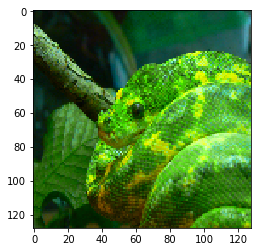

In [15]:
i = 0
sample = images_dev[:,i]
target = labels_dev[0,i]
prediction = predict(sample,Weights,Bias)
print("It says it's a {}, it's actually a {}".format(species(prediction),species(target)))
print(("Good guess model! Take a cookie." if target == prediction else "Bad model! No cookie for you."))
plt.imshow(images_dev_orig[i])
plt.show()

## Discussion
The results are consistent. Since this is a simple model and our first shot at the problem, a 91% train set accuracy is a confortable starting point. Also, the dev set accuracy was roughly 15% above random guessing, meaning that logistic regression is actually discovering distinguishig features between the two classes. There is still room for a thorough error analisys, including cross validation and improving the bias and variance. There is also room for dealing with the initial train-dev error instability. We already do have a quick asnd dirty first iteration on this project using LR, so we will address those issues over the next session of this project.

## Conclusion
I, Hermes, am very relieved with this result. Jeanne and Marrie don't seem to be that impressed, actually they possess an aggressive stance towards snakes problems (by the way those are my lovely cats). First, as a rule of thumb, any result below random guessing should be disregarded and the whole procedure examined, which is not the case. Second, overfitting is a very bad thing when delivering a model, but it should be a goal for the beginning of a project. Meaning, if your model can't even overfit the training data, it will be tougher to come up with decent dev and test (validation) errors. Since 91% train error is way above random guessing, this indicates that neural networks is a good choice for this problem. Finally, since this model is very simple and has too few hyperparameters, it was only intended to give an overall look to the modelling problem. We will make an improved error analisys and hyperparameter tuning on the next simplest NN model (2 - DeepSnakes - Shallow NN).